### Grms calculation from vibration psd
This script will calculate the overall Grms level based on the break points in the vibration psd.

[Link](https://femci.gsfc.nasa.gov/random/randomgrms.html) to NASA's FINITE ELEMENT MODELING CONTINUOUS IMPROVEMENT page on Calulating Grms (Root-Mean-Square Acceleration).
***
##### Calulating Grms (Root-Mean-Square Acceleration)
It is very easy to describe the Grms (root-mean-square acceleration, sometimes written as GRMS or Grms or grms or grms) value as just the square root of the area under the ASD vs. frequency curve, which it is. But to physically interpret this value we need to look at $G_{rms}$ a different way. The easiest way to think of the Grms is to first look at the mean square acceleration.

Mean-square acceleration is the average of the square of the acceleration over time. That is, if you were to look at a time history of an accelerometer trace and were to square this time history and then determine the average value for this squared acceleration over the length of the time history, that would be the mean square acceleration. Using the mean square value keeps everything positive.

The $G_{rms}$ is the root-mean-square acceleration (or rms acceleration), which is just the square root of the mean square acceleration determined above.

If the accelerometer time history is a pure sinusoid with zero mean value, e.g., a steady-state vibration, the rms acceleration would be .707 times the peak value of the sinusoidal acceleration (if just a plain average were used, then the average would be zero). If the accelerometer time history is a stationary Gaussian random time history, the rms acceleration (also called the 1 sigma acceleration) would be related to the statistical properties of the acceleration time history (you may have to refresh your probability and statistics knowledge for this):
* 68.3% of the time, the acceleration time history would have peaks that would not exceed the +/- 1 sigma accelerations.
* 95.4% of the time, the acceleration time history would have peaks that would not exceed the +/- 2 sigma accelerations.
* 99.7% of the time, the acceleration time history would have peaks that would not exceed the +/- 3 sigma accelerations.

There is no theoretical maximum value for the Gaussian random variable; however, we typically design to 3 sigma since it would only be theoretically exceeded 0.3% of the time. In addition, from a practical point of view, we know that it would be physically impossible to achieve unreasonably high sigma values.
***
Steps:
1. calculate the number of octaves.
2. calculate the dB value.
3. calculate the slope, m, of the segment between the frequencies FL and FH.
4. calculate the area under the curve between the frequencies FL and FH.
5. take the square root of the area for the Grms value.

In [2]:
import numpy as np
import collections
import matplotlib.pyplot as plt

In [2]:
# point in the vibration profile (frequency in Hz, G^2/Hz)
psd = dict([(10.0, 0.4), (21.0, 0.4), (22.4, 0.74), (28.2, 0.74), (30.0, 0.8), (35.5, 0.4),
    (41.0, 0.168), (63.0, 0.6), (150.0, 0.16), (600.0, 0.16), (2000.0, 0.0304)])
#make sure the dictionary is ordered
psd = collections.OrderedDict(sorted(psd.items()))

In [3]:
psd

OrderedDict([(10.0, 0.4),
             (21.0, 0.4),
             (22.4, 0.74),
             (28.2, 0.74),
             (30.0, 0.8),
             (35.5, 0.4),
             (41.0, 0.168),
             (63.0, 0.6),
             (150.0, 0.16),
             (600.0, 0.16),
             (2000.0, 0.0304)])

In [4]:
plt.grid(True)
plt.xlabel('Frequency, Hz')
plt.ylabel('PSD, G^2/Hz')
plt.loglog(list(psd.keys()), list(psd.values()))

#### The NASA method of calculating Grms from the PSD

In [5]:
# step 1, calculate the octaves between each frequency
freq = list(psd.keys())
g2Hz = list(psd.values())
oct = np.zeros(len(freq))
for i in range(len(freq)-1):
    oct[i+1] = np.log10(freq[i+1]/freq[i])/np.log10(2)

In [6]:
# step 2: calculate the dB values of the ratio between break points
dB = np.zeros(len(g2Hz))
for i in range(len(g2Hz)-1):
    dB[i+1] = 10*np.log10(g2Hz[i+1]/g2Hz[i])

In [7]:
# step 3: calculate the slope of the segment between the frequencies FL and FH
slope = np.zeros(len(freq))
slope[1:] = dB[1:]/oct[1:]

In [9]:
# step 4: calculate the area under the curve between the frequencies FL and FH, if math fails see link for alternate formula
area =  np.zeros(len(freq))
for i in range(len(g2Hz)-1):
    if slope[i+1] != -10*np.log10(2):
        area[i+1] = 10*np.log10(2)*(g2Hz[i+1]/(10*np.log10(2)+slope[i+1]))*(freq[i+1]-freq[i]*
                (freq[i]/freq[i+1])**(slope[i+1]/(10*np.log10(2))))
    else:
        area[i+1] = g2Hz[i]*freq[i]*np.log(freq[i+1]-freq[i])

In [10]:
print('Grms value: {:.3f}'.format(np.sqrt(area.sum())))

Grms value: 14.642


##### just calculating the area under the curve gives a different answer, why??

In [11]:
area_by_int = np.trapz(g2Hz, freq)
print('Grms value: {:.3f}'.format(np.sqrt(area_by_int)))

Grms value: 16.203


To compute the RMS values from the breakpoints we need to compute the area under the curve defined by the breakpoints. At first glance this appears simple because the area can be split up into a group of squares and triangles, which are easy to compute. But note that the triangles are the result of straight lines on log-log graph paper, and not on linear graph paper. We can still take advantage of the triangles, however we need to use a special formula for computing the area of triangles on log-log graph paper.

The definition of a straight line on log-log graphs between two breakpoints (f1,a1) and (f2,a2) is a power relationship, where the slope is the exponent, and the offset is the multiplicative factor.

#### test example

In [93]:
# point in the vibration profile (frequency in Hz, G^2/Hz)
psd1 = dict([(20.0, 0.01005), (80.0, 0.04), (350., 0.04), (2000., 0.00704)])
#make sure the dictionary is ordered
psd1 = collections.OrderedDict(sorted(psd1.items()))

In [28]:
# point in the vibration profile (frequency in Hz, G^2/Hz)
psd1 = dict([(10.0, 1.0), (100.0, 10.0), (1000., 10.0), (10000., 1.0)])
#make sure the dictionary is ordered
psd1 = collections.OrderedDict(sorted(psd1.items()))

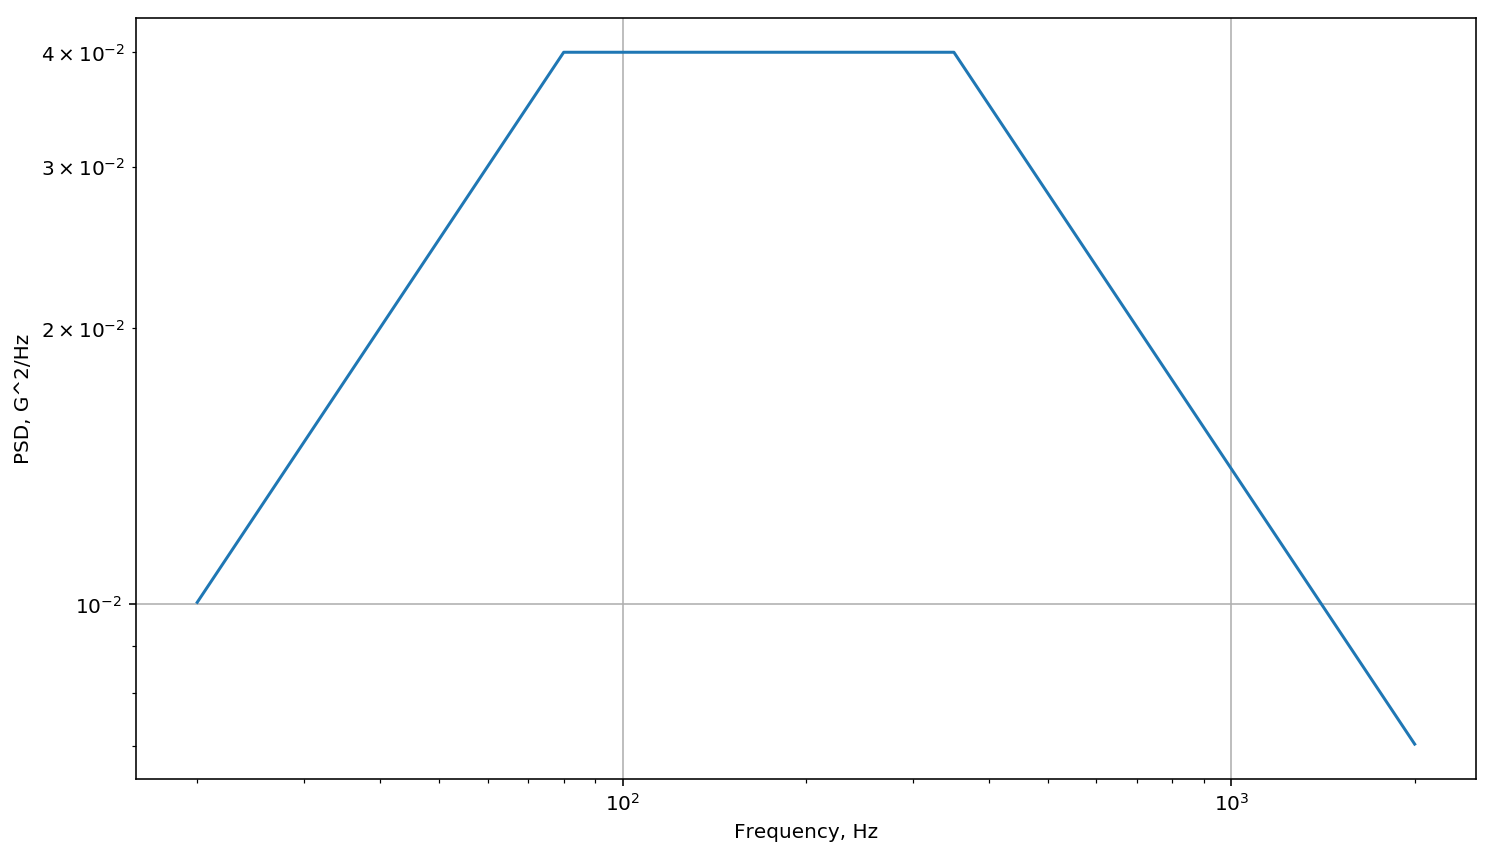

In [94]:
plt.grid(True)
plt.xlabel('Frequency, Hz')
plt.ylabel('PSD, G^2/Hz')
plt.loglog(list(psd1.keys()), list(psd1.values()))

In [110]:
# step 3: calculate the slope of the segment between the frequencies FL and FH
freq = list(psd1.keys())
g2Hz = list(psd1.values())
m = np.zeros(len(freq))
b = np.zeros(len(freq))
for i in range(len(freq)-1):
    m[i+1] = (g2Hz[i+1]-g2Hz[i])/(freq[i+1]-freq[i])
    b[i+1] = g2Hz[i]-m[i+1]*freq[i]

In [111]:
m

array([  0.00000000e+00,   4.99166667e-04,   0.00000000e+00,
        -1.99757576e-05])

In [97]:
g2Hz

[0.01005, 0.04, 0.04, 0.00704]

In [98]:
freq

[20.0, 80.0, 350.0, 2000.0]

In [113]:
b

array([  0.00000000e+00,   6.66666667e-05,   4.00000000e-02,
         4.69915152e-02])

In [114]:
def f(x,m,b):
    return 10*np.log10(x*m+b)

In [116]:
i = 1
f(80,m[i],b[i])

-13.979400086720375

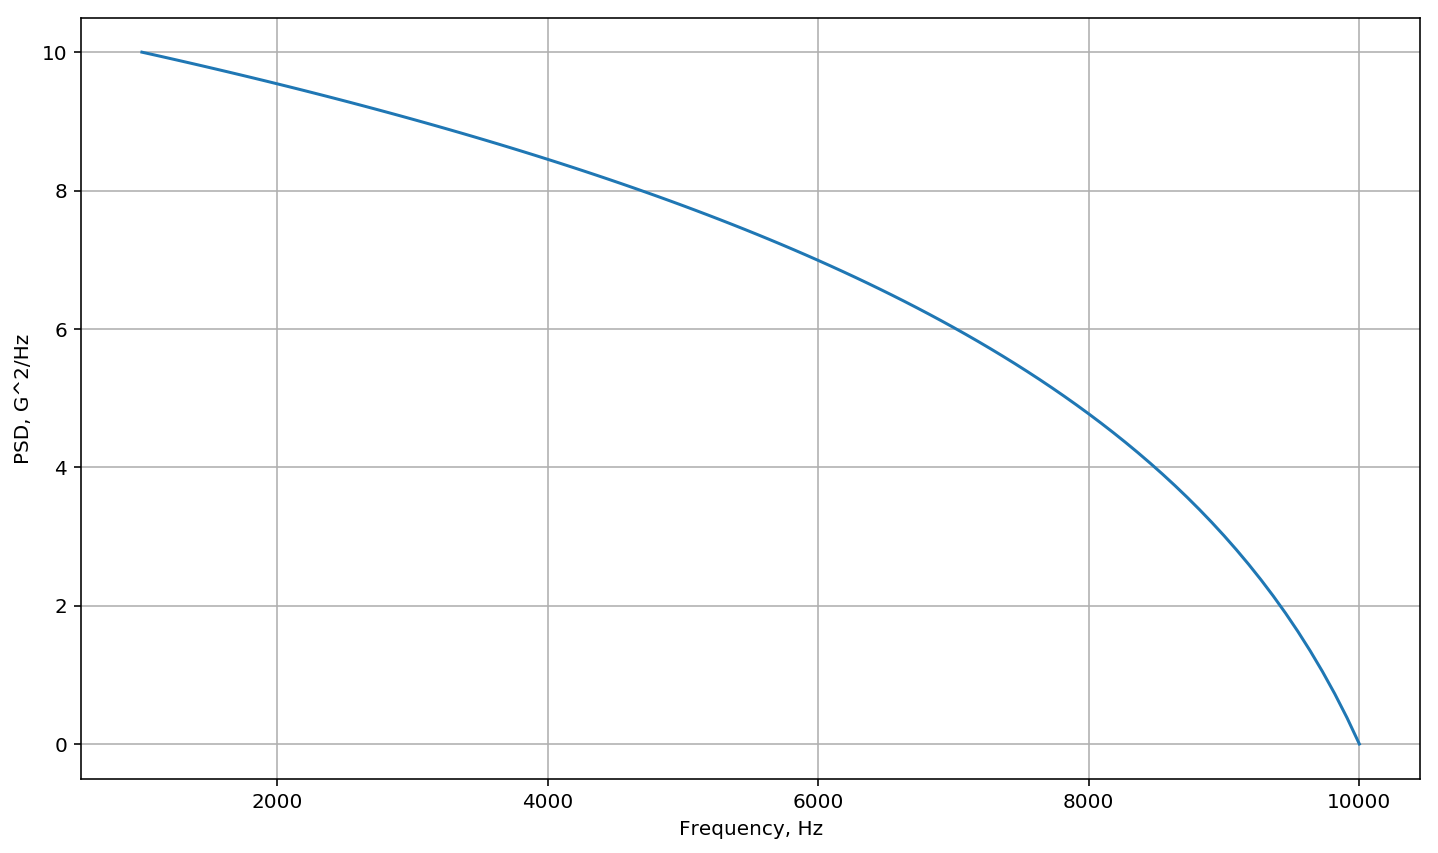

In [85]:
x = np.linspace(1000, 10000, 100, endpoint=True)
plt.grid(True)
plt.xlabel('Frequency, Hz')
plt.ylabel('PSD, G^2/Hz')
plt.plot(x, f(x,m[3],b[3]))

In [87]:
import scipy.integrate

In [109]:
i = 0
d = m[i+1]
e = b[i+1]
def f(x):
    return 10*np.log10(x*d+e)

scipy.integrate.quad(f, freq[i], freq[i+1])

(-978.560714534961, 1.0228580623214997e-10)

In [119]:
i = 1
d = m[i+1]
e = b[i+1]
def f(x):
    return 10*np.log10(x*d+e)

scipy.integrate.quad(f, freq[i], freq[i+1])

(-3774.438023414501, 4.190467998615445e-11)

In [120]:
i = 2
d = m[i+1]
e = b[i+1]
def f(x):
    return 10*np.log10(x*d+e)

scipy.integrate.quad(f, freq[i], freq[i+1])

(-27572.850632516907, 1.1831605083292204e-06)

In [131]:
10**(978.560714534961/10)

1.3929276088391191e-98

In [128]:
np.log10(3774.438023414501)

3.5768522986146243

In [129]:
np.log10(27572.850632516907)

4.4404816681722767

In [107]:
f(80)

-13.979400086720375

In [108]:
freq

[20.0, 80.0, 350.0, 2000.0]

In [117]:
m

array([  0.00000000e+00,   4.99166667e-04,   0.00000000e+00,
        -1.99757576e-05])

In [118]:
b

array([  0.00000000e+00,   6.66666667e-05,   4.00000000e-02,
         4.69915152e-02])